# Generative Adversarial Network for Fashion-MNIST

Here, a generative adversarial network (GAN) is trained on the Fashion-MNIST dataset. Objective of the GAN is to generate new fashion clothes.
GANs were developed by Ian Goodfellow et al. in 2014 ([see](https://arxiv.org/abs/1406.2661)).
GANs relies on the idea to have two networks, a generator $G$ and a discrimininator $D$, competing agiant each other. While $G$ tries to create fake data, the discriminator task is to determine whether the data passed to it is drawn from real data or it is generated by $G$. It is, in fact, similar to a two-party game, in which $G$ and $D$ are improving their performance throguh competition between each other. The value function for GAN can be written as,

$\min \max V(D, G) = \mathrm{E}_{x\sim p_{data(x)}} [\log D(x)] + \mathrm{E}_{z\sim p_z(z)} [ \log (1-D(G(z))]$

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

![GAN diagram](assets/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, using Fashion-MNIST images as data. The latent sample is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can foold the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. The code is written in TensorFlow.

In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('Fashion_MNIST_data')
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('Fashion_MNIST_data', kind='train')
X_test, y_test = mnist_reader.load_mnist('Fashion_MNIST_data', kind='t10k')

Extracting Fashion_MNIST_data\train-images-idx3-ubyte.gz
Extracting Fashion_MNIST_data\train-labels-idx1-ubyte.gz
Extracting Fashion_MNIST_data\t10k-images-idx3-ubyte.gz
Extracting Fashion_MNIST_data\t10k-labels-idx1-ubyte.gz


## Real Data Visulaization

See Fashion dataset samples!

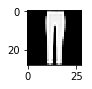

In [3]:
fig, ax = plt.subplots(figsize=(1, 1))
img = X_train[308]

plt.imshow(img.reshape((28, 28)), cmap='Greys_r')



##  GAN Inputs

Two sets of input should be created for the network. Inputs of the generator, which are random, are called inputs_z. Inputs of discriminator, which are fashion-MNIST data set, are called inputs_real.

In [4]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

#  GAN Network 

The GAN network is shown in figure below.

![GAN Network](assets/gan_network.png)


## Generator Network
The generator network is created here with two hidden layers using leaky ReLU to aviod gradient vanishing and in order to make sure that it has enough capacity for function approximation. 

### TensorFlow Variable Scope

During training, the generator and discriminator are optimized seperately. Furthermore, it is possible to use the reuse keyword in order to sample during training or after training. 


### Action Function
#### Leaky ReLU
The leaky ReLU is defined as follow, 

$$
f(x) = max(\alpha \times x, x)
$$
where $x$ is the input. If it is positive, the ouput is $x$ , otherwise, it is $\alpha \times x$.

#### Tanh 
According to previous studies, the generator has the best performance with $tanh$ for the its output.

## Discriminator Network

The only difference between the discriminator and generator networks is the ouput layer. The discriminator uses sigmoid activation instead of $tanh$.
#### Sigmoid
The Sigmoid function is defined as,
$$
    \sigma (x) = \frac{1}{1+\exp(-x)}
$$

In [5]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        h2 = tf.layers.dense(h1, n_units * 2 , activation=None)
        h2 = tf.maximum(alpha * h2, h2)
        # Logits and tanh output
        logits = tf.layers.dense(h2, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [6]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        h2 = tf.layers.dense(h1, n_units / 2, activation=None)
        h2 = tf.maximum(alpha * h2, h2)
        
        logits = tf.layers.dense(h2, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [7]:
# Size of input image to discriminator
input_size = 784
# Size of latent vector to generator
z_size = 128
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 256
d_hidden_size = 256
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

## Build network

The networks for both $G$ and $D$ are created here. Furthermore, two networks are built for $D$, one for real input and one for generated data by $G$. As the weights should be the same for both real and generated inputs,the reuse keyword is used. For the generated data, it is ouput of $G$, here defined as `g_model`. 
Therefore, the real input of the discriminator is `discriminator(input_real)` while the fake discriminator is `discriminator(g_model, reuse=True)`.

In [8]:
tf.reset_default_graph()
#  Input placeholders are created
input_real, input_z = model_inputs(input_size, z_size)

# The generator network is created
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

# The discriminator networks are created one for real input and one for generated input
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

##  $D$ and $G$ Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_loss_real + d_loss_fake`. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the images in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the real image logits, we'll use `d_logits_real` which we got from the discriminator in the cell above. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as label smoothing, typically used with classifiers to improve performance. In TensorFlow, it looks something like `labels = tf.ones_like(tensor) * (1 - smooth)`

The discriminator loss for the fake data is similar. The logits are `d_logits_fake`, which we got from passing the generator output to the discriminator. These fake logits are used with labels of all zeros. Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_fake`, the fake image logits. But, now the labels are all ones. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.

In [9]:
# Calculate losses
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [10]:
# Optimizers
learning_rate = 0.0005

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [11]:
batch_size = 128
epochs = 500
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(data.train.num_examples//batch_size):
            batch = data.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.normal(0, 1, size=(batch_size, z_size)) # modified
            #batch_z = batch_images#batch[0].reshape((z_size, 784)) #modified
            #batch_z = 2 * batch_z - 1
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/500... Discriminator Loss: 0.4445... Generator Loss: 2.5544
Epoch 2/500... Discriminator Loss: 0.3916... Generator Loss: 3.3050
Epoch 3/500... Discriminator Loss: 0.4258... Generator Loss: 4.1287
Epoch 4/500... Discriminator Loss: 0.4535... Generator Loss: 3.8728
Epoch 5/500... Discriminator Loss: 0.4707... Generator Loss: 5.3763
Epoch 6/500... Discriminator Loss: 0.5026... Generator Loss: 3.7498
Epoch 7/500... Discriminator Loss: 0.5089... Generator Loss: 2.9156
Epoch 8/500... Discriminator Loss: 0.7063... Generator Loss: 2.0766
Epoch 9/500... Discriminator Loss: 0.6867... Generator Loss: 2.4870
Epoch 10/500... Discriminator Loss: 0.7137... Generator Loss: 2.2154
Epoch 11/500... Discriminator Loss: 1.0803... Generator Loss: 1.9172
Epoch 12/500... Discriminator Loss: 1.1510... Generator Loss: 1.6615
Epoch 13/500... Discriminator Loss: 0.7016... Generator Loss: 2.2098
Epoch 14/500... Discriminator Loss: 0.7065... Generator Loss: 2.1633
Epoch 15/500... Discriminator Loss: 0.9096.

Epoch 120/500... Discriminator Loss: 1.2222... Generator Loss: 0.9717
Epoch 121/500... Discriminator Loss: 1.2987... Generator Loss: 1.2569
Epoch 122/500... Discriminator Loss: 1.1835... Generator Loss: 1.1627
Epoch 123/500... Discriminator Loss: 1.3167... Generator Loss: 1.2968
Epoch 124/500... Discriminator Loss: 1.2159... Generator Loss: 1.1090
Epoch 125/500... Discriminator Loss: 1.1471... Generator Loss: 1.1437
Epoch 126/500... Discriminator Loss: 1.4171... Generator Loss: 0.9231
Epoch 127/500... Discriminator Loss: 1.2865... Generator Loss: 1.0216
Epoch 128/500... Discriminator Loss: 1.2369... Generator Loss: 1.0391
Epoch 129/500... Discriminator Loss: 1.2071... Generator Loss: 1.0845
Epoch 130/500... Discriminator Loss: 1.2739... Generator Loss: 1.1331
Epoch 131/500... Discriminator Loss: 1.2333... Generator Loss: 1.2626
Epoch 132/500... Discriminator Loss: 1.0937... Generator Loss: 1.5019
Epoch 133/500... Discriminator Loss: 1.1960... Generator Loss: 1.2441
Epoch 134/500... Dis

Epoch 238/500... Discriminator Loss: 1.4123... Generator Loss: 0.9798
Epoch 239/500... Discriminator Loss: 1.3045... Generator Loss: 0.9807
Epoch 240/500... Discriminator Loss: 1.2923... Generator Loss: 0.8963
Epoch 241/500... Discriminator Loss: 1.3666... Generator Loss: 0.8984
Epoch 242/500... Discriminator Loss: 1.2666... Generator Loss: 1.2033
Epoch 243/500... Discriminator Loss: 1.4704... Generator Loss: 0.9310
Epoch 244/500... Discriminator Loss: 1.3469... Generator Loss: 0.9271
Epoch 245/500... Discriminator Loss: 1.1551... Generator Loss: 1.1787
Epoch 246/500... Discriminator Loss: 1.3652... Generator Loss: 0.8369
Epoch 247/500... Discriminator Loss: 1.2449... Generator Loss: 1.2005
Epoch 248/500... Discriminator Loss: 1.4630... Generator Loss: 0.9089
Epoch 249/500... Discriminator Loss: 1.2539... Generator Loss: 1.2967
Epoch 250/500... Discriminator Loss: 1.2541... Generator Loss: 1.0586
Epoch 251/500... Discriminator Loss: 1.2802... Generator Loss: 0.9205
Epoch 252/500... Dis

Epoch 356/500... Discriminator Loss: 1.3764... Generator Loss: 0.8803
Epoch 357/500... Discriminator Loss: 1.3771... Generator Loss: 1.0234
Epoch 358/500... Discriminator Loss: 1.1273... Generator Loss: 1.0060
Epoch 359/500... Discriminator Loss: 1.4354... Generator Loss: 1.1628
Epoch 360/500... Discriminator Loss: 1.3034... Generator Loss: 0.9663
Epoch 361/500... Discriminator Loss: 1.2677... Generator Loss: 1.1238
Epoch 362/500... Discriminator Loss: 1.4386... Generator Loss: 0.8341
Epoch 363/500... Discriminator Loss: 1.3123... Generator Loss: 0.9299
Epoch 364/500... Discriminator Loss: 1.3573... Generator Loss: 0.8885
Epoch 365/500... Discriminator Loss: 1.3594... Generator Loss: 0.8705
Epoch 366/500... Discriminator Loss: 1.3179... Generator Loss: 0.9060
Epoch 367/500... Discriminator Loss: 1.3673... Generator Loss: 0.8525
Epoch 368/500... Discriminator Loss: 1.3546... Generator Loss: 0.7900
Epoch 369/500... Discriminator Loss: 1.1726... Generator Loss: 1.1999
Epoch 370/500... Dis

Epoch 474/500... Discriminator Loss: 1.2838... Generator Loss: 0.9862
Epoch 475/500... Discriminator Loss: 1.5601... Generator Loss: 0.7261
Epoch 476/500... Discriminator Loss: 1.3208... Generator Loss: 1.1368
Epoch 477/500... Discriminator Loss: 1.3248... Generator Loss: 0.8759
Epoch 478/500... Discriminator Loss: 1.3095... Generator Loss: 0.8524
Epoch 479/500... Discriminator Loss: 1.3913... Generator Loss: 0.8592
Epoch 480/500... Discriminator Loss: 1.3504... Generator Loss: 0.8418
Epoch 481/500... Discriminator Loss: 1.3890... Generator Loss: 0.7970
Epoch 482/500... Discriminator Loss: 1.3007... Generator Loss: 1.0852
Epoch 483/500... Discriminator Loss: 1.1939... Generator Loss: 1.1585
Epoch 484/500... Discriminator Loss: 1.3082... Generator Loss: 1.0517
Epoch 485/500... Discriminator Loss: 1.3696... Generator Loss: 0.9626
Epoch 486/500... Discriminator Loss: 1.3865... Generator Loss: 0.8943
Epoch 487/500... Discriminator Loss: 1.4079... Generator Loss: 0.8327
Epoch 488/500... Dis

## Training loss

Here we'll check out the training losses for the generator and discriminator.

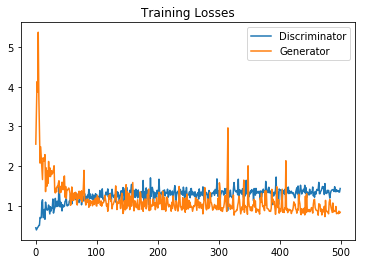

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.

In [13]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes



In [14]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

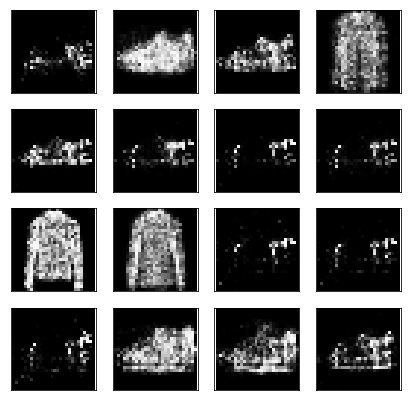

In [15]:
_ = view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs. With bonus optical illusion!

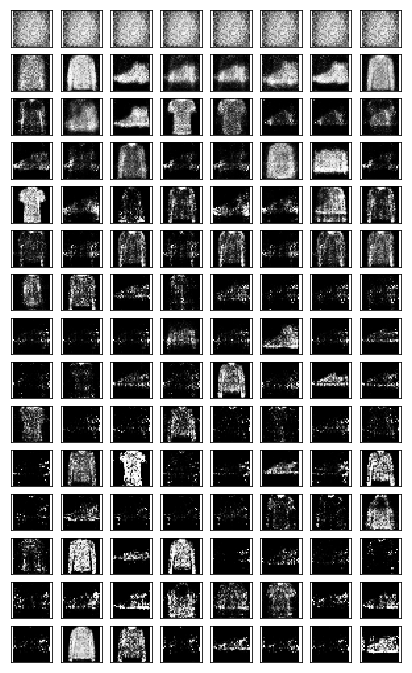

In [16]:
rows, cols = 15, 8
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

Initial noisy inputs turn into different clothes in the Fashion-MNIST database as it goes through $G$ network.


## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector $z$ and we'll get new samples!

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


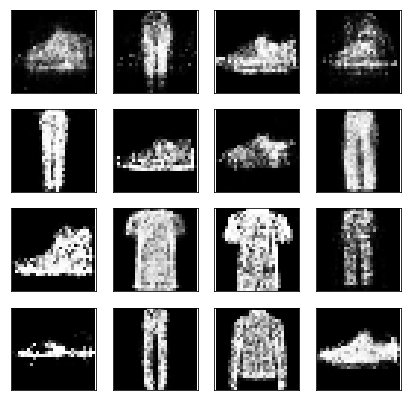

In [17]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.normal(0.0, 1.0, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])